In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [0]:
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content/gdrive/My Drive/Kaggle"

In [0]:
%cd /content/gdrive/My Drive/Kaggle

/content/gdrive/My Drive/Kaggle


In [0]:
import pandas as pd
import numpy as np
import re
import nltk
import string
import tensorflow as tf
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed, Bidirectional
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
from keras import backend as K
from tensorflow.python.keras.layers import Layer
from tensorflow.python.keras import backend as K
from sklearn.model_selection import train_test_split
from keras.preprocessing.text import Tokenizer 
from keras.preprocessing.sequence import pad_sequences
nltk.download('stopwords')
from nltk.corpus import stopwords


Using TensorFlow backend.


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
# Read the Data
data1 = pd.read_csv('Reviews.csv')
print(data1.columns)
#remove uneccessary columns 
data1 = data1.drop(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time'], axis = 1)
print("Removed unecessary columns")
for i in range(5):
  print(data1.Text[i])
  print(data1.Summary[i])
  print('\n')

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')
Removed unecessary columns
I have bought several of the Vitality canned dog food products and have found them all to be of good quality. The product looks more like a stew than a processed meat and it smells better. My Labrador is finicky and she appreciates this product better than  most.
Good Quality Dog Food


Product arrived labeled as Jumbo Salted Peanuts...the peanuts were actually small sized unsalted. Not sure if this was an error or if the vendor intended to represent the product as "Jumbo".
Not as Advertised


This is a confection that has been around a few centuries.  It is a light, pillowy citrus gelatin with nuts - in this case Filberts. And it is cut into tiny squares and then liberally coated with powdered sugar.  And it is a tiny mouthful of heaven.  Not too chewy, and very flavorful.  I highly recommend t

In [0]:
# Read the Data
data2 = pd.read_csv('kindle_reviews.csv')
print(data2.columns)
#remove uneccessary columns 
data2 = data2.drop(['Unnamed: 0', 'asin', 'helpful', 'overall','reviewTime', 
        'reviewerID', 'reviewerName','unixReviewTime'], axis = 1)
print("Removed unecessary columns")
data2.rename(index = str, columns = {'summary':'Summary', 'reviewText':'Text'}, inplace = True)
data2 = data2[['Summary','Text']]
# print(data2.head())
for i in range(5):
  print(data2.Text[i])
  print(data2.Summary[i])
  print('\n')

Index(['Unnamed: 0', 'asin', 'helpful', 'overall', 'reviewText', 'reviewTime',
       'reviewerID', 'reviewerName', 'summary', 'unixReviewTime'],
      dtype='object')
Removed unecessary columns
I enjoy vintage books and movies so I enjoyed reading this book.  The plot was unusual.  Don't think killing someone in self-defense but leaving the scene and the body without notifying the police or hitting someone in the jaw to knock them out would wash today.Still it was a good read for me.
Nice vintage story


This book is a reissue of an old one; the author was born in 1910. It's of the era of, say, Nero Wolfe. The introduction was quite interesting, explaining who the author was and why he's been forgotten; I'd never heard of him.The language is a little dated at times, like calling a gun a &#34;heater.&#34;  I also made good use of my Fire's dictionary to look up words like &#34;deshabille&#34; and &#34;Canarsie.&#34; Still, it was well worth a look-see.
Different...


This was a fairly 

In [0]:
data = pd.concat([data2, data1])
print(data.head())

              Summary                                               Text
0  Nice vintage story  I enjoy vintage books and movies so I enjoyed ...
1        Different...  This book is a reissue of an old one; the auth...
2               Oldie  This was a fairly interesting read.  It had ol...
3  I really liked it.  I'd never read any of the Amy Brewster mysteri...
4      Period Mystery  If you like period pieces - clothing, lingo, y...


In [0]:
#checking for any empty data
print("Checking for empty data: ")
print(data.isnull().sum())
print('\n')
#remove any empty data 
data = data.dropna()
data = data.reset_index(drop = True)

#checking if the empty data has been deleted
print("Checking again for empty data: ")
print(data.isnull().sum())

print(data.head())

Checking for empty data: 
Summary    28
Text       22
dtype: int64


Checking again for empty data: 
Summary    0
Text       0
dtype: int64
              Summary                                               Text
0  Nice vintage story  I enjoy vintage books and movies so I enjoyed ...
1        Different...  This book is a reissue of an old one; the auth...
2               Oldie  This was a fairly interesting read.  It had ol...
3  I really liked it.  I'd never read any of the Amy Brewster mysteri...
4      Period Mystery  If you like period pieces - clothing, lingo, y...


In [0]:
#expand common contractions inside the text
contraction_expander = { 
"ain't": "am not", "aren't": "are not", "can't": "cannot", "can't've": "cannot have", "'cause": "because", "could've": "could have", "couldn't": "could not",
"couldn't've": "could not have", "didn't": "did not", "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hadn't've": "had not have", "hasn't": "has not",
"haven't": "have not", "he'd": "he would", "he'd've": "he would have","he'll": "he will", "he's": "he is", "how'd": "how did", "how'll": "how will","how's": "how is",
"i'd": "i would","i'll": "i will","i'm": "i am","i've": "i have", "isn't": "is not","it'd": "it would","it'll": "it will","it's": "it is","let's": "let us","ma'am": "madam",
"mayn't": "may not","might've": "might have","mightn't": "might not","must've": "must have","mustn't": "must not","needn't": "need not","oughtn't": "ought not","shan't": "shall not",
"sha'n't": "shall not","she'd": "she would", "she'll": "she will","she's": "she is","should've": "should have","shouldn't": "should not","that'd": "that would", "that's": "that is",
"there'd": "there had","there's": "there is","they'd": "they would","they'll": "they will", "they're": "they are","they've": "they have","wasn't": "was not","we'd": "we would",
"we'll": "we will","we're": "we are","we've": "we have","weren't": "were not","what'll": "what will","what're": "what are","what's": "what is", "what've": "what have",
"where'd": "where did","where's": "where is","who'll": "who will","who's": "who is", "won't": "will not","wouldn't": "would not","you'd": "you would","you'll": "you will",
"you're": "you are"
}

In [0]:
#function to clean the text and summary
stop_words = set(stopwords.words('english')) 
def content_cleaner(content, remove_stop_words=True):
    text = content.lower()

    #expand the contractions
    expanded_form = []
    for i in text.split():
      if i in contraction_expander:
        expanded_form = expanded_form + [contraction_expander[i]]
      else:
        expanded_form = expanded_form + [i]
    text = ' '.join(expanded_form)

    #remove the punctuations
    regex = re.compile('[%s]' % re.escape(string.punctuation))         
    text = regex.sub(" ", text)
    
    #whitespace
    text = re.sub('\s+', ' ', text).strip()  

    #stopwords removal
    if remove_stop_words:
        remove = [i for i in text.split() if not i in stop_words]  
        text = (" ".join(remove)).strip()

    return text

#clean the text and append into an array
clean_texts = []
for text in data.Text:
    clean_texts.append(content_cleaner(text,remove_stop_words=True))
print("Text Appended.")

#clean the summary and append into an array
clean_summaries = []
for summary in data.Summary:
    clean_summaries.append(content_cleaner(summary,remove_stop_words=False))
print("Summaries Appended.")

#checking 
for i in range(3):
  print("Text:\n", clean_texts[i])
  print("Summary:\n", clean_summaries[i])

Text Appended.
Summaries Appended.
Text:
 enjoy vintage books movies enjoyed reading book plot unusual think killing someone self defense leaving scene body without notifying police hitting someone jaw knock would wash today still good read
Summary:
 nice vintage story
Text:
 book reissue old one author born 1910 era say nero wolfe introduction quite interesting explaining author forgotten would never heard language little dated times like calling gun 34 heater 34 also made good use fire dictionary look words like 34 deshabille 34 34 canarsie 34 still well worth look see
Summary:
 different
Text:
 fairly interesting read old style terminology glad get read story coarse crasslanguage read fun relaxation like free ebooksbecause check writer decide intriguing innovative enough command englishthat convey story without crude language
Summary:
 oldie


In [0]:
#see the distirbution
def distribution_length(text):
    lengths = []
    for sentence in text:
        lengths.append(len(sentence))
    return pd.DataFrame(lengths, columns=['counts'])

lengths_summaries = distribution_length(clean_summaries)
lengths_texts = distribution_length(clean_texts)

print("Describe Summaries:")
print(lengths_summaries.describe())
print('\n')
print("Describe Texts:")
print(lengths_texts.describe())

Describe Summaries:
             counts
count  1.551023e+06
mean   2.211637e+01
std    1.479597e+01
min    0.000000e+00
25%    1.200000e+01
50%    1.800000e+01
75%    2.900000e+01
max    2.490000e+02


Describe Texts:
             counts
count  1.551023e+06
mean   3.314817e+02
std    3.977787e+02
min    0.000000e+00
25%    1.080000e+02
50%    1.930000e+02
75%    3.830000e+02
max    1.490900e+04


In [0]:
#checking lengths
count_text = 0
for i in clean_texts:
    if(len(i.split()) >= 10):
        count_text = count_text + 1
print("Minimum Text: ")
print(count_text/len(clean_texts))

count_summary = 0
for i in clean_summaries:
    if(len(i.split()) >= 5):
        count_summary = count_summary + 1
print("Minimum Summary: ")
print(count_summary/len(clean_summaries))
            
count_text = 0
for i in clean_texts:
    if(len(i.split()) <= 80):
        count_text = count_text + 1
print("Maximum Text: ")
print(count_text/len(clean_texts))

count_summary = 0
for i in clean_summaries:
    if(len(i.split()) <= 8):
        count_summary = count_summary + 1
print("Maximum Summary: ")
print(count_summary/len(clean_summaries))
            

Minimum Text: 
0.9702377076290938
Minimum Summary: 
0.3366887531648467
Maximum Text: 
0.8343570662717446
Maximum Summary: 
0.9253931115141426


In [0]:
#place limitations on data due to computational limitations
minimum_text_length = 10
maximum_text_length = 50
minimum_summary_length = 3
maximum_summary_length = 8
# Summaries: 770612

#arrays to store summaries & texts that fit the requirements
accepted_summaries = []
accepted_texts = []

for i in range(len(clean_texts)):
  if(len(clean_summaries[i].split())>=minimum_summary_length and len(clean_summaries[i].split())<=maximum_summary_length and
        len(clean_texts[i].split()) >=minimum_text_length and len(clean_texts[i].split())<=maximum_text_length ):
    accepted_summaries.append(clean_summaries[i])
    accepted_texts.append(clean_texts[i])

#length of summaries and text
print("Summaries:", len(accepted_summaries))
print("Text:", len(accepted_texts))


Summaries: 586072
Text: 586072


In [0]:
#see the distirbution of the accepted text and summaries
lengths_accepted_summaries = distribution_length(accepted_summaries)
lengths_accepted_texts = distribution_length(accepted_texts)

print("Describe Summaries:")
print(lengths_accepted_summaries.describe())
print('\n')
print("Describe Texts:")
print(lengths_accepted_texts.describe())

Describe Summaries:
              counts
count  586072.000000
mean       23.459787
std         8.601130
min         5.000000
25%        17.000000
50%        22.000000
75%        29.000000
max        74.000000


Describe Texts:
              counts
count  586072.000000
mean      167.562765
std        75.093653
min        27.000000
25%       104.000000
50%       154.000000
75%       223.000000
max       434.000000


In [0]:
# Add tokens at the begining and the end of the summaries
accepted_summaries = list(map(lambda x: 'starttoken '+ x + ' endtoken', accepted_summaries))

In [0]:
text_train,text_val,summary_train, summary_val = train_test_split(np.array(accepted_texts),np.array(accepted_summaries), test_size = 0.2, random_state=0)

#tokenizer for text 
x_tokenizer = Tokenizer()
x_tokenizer.fit_on_texts(list(text_train))

count = 0
for i in x_tokenizer.word_counts.items():
  count = count + 1

#tokenizer for text 
x_tokenizer = Tokenizer(num_words = count)
x_tokenizer.fit_on_texts(list(text_train))

#convert text sequences into integer sequences
text_train = x_tokenizer.texts_to_sequences(text_train)
text_val = x_tokenizer.texts_to_sequences(text_val)

#ensures all sequences in the list have the same length
text_train = pad_sequences(text_train, maxlen = maximum_text_length, padding='post')
text_val = pad_sequences(text_val, maxlen = maximum_text_length, padding='post')

x_vocab = x_tokenizer.num_words + 1

# #tokenizer for summary
y_tokenizer = Tokenizer()
y_tokenizer.fit_on_texts(list(summary_train))

count = 0
for i in y_tokenizer.word_counts.items():
  count = count + 1

y_tokenizer = Tokenizer(num_words = count)
y_tokenizer.fit_on_texts(list(summary_train))

#convert text sequences into integer sequences
summary_train = y_tokenizer.texts_to_sequences(summary_train)
summary_val = y_tokenizer.texts_to_sequences(summary_val)

#padding zero upto maximum length
summary_train = pad_sequences(summary_train, maxlen = maximum_summary_length, padding='post')
summary_val = pad_sequences(summary_val, maxlen = maximum_summary_length, padding='post')

y_vocab = y_tokenizer.num_words + 1


In [0]:
#third party Attention 
#third party implementation layer
class AttentionLayer(Layer):
    """
    This class implements Bahdanau attention (https://arxiv.org/pdf/1409.0473.pdf).
    There are three sets of weights introduced W_a, U_a, and V_a
     """

    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        assert isinstance(input_shape, list)
        # Create a trainable weight variable for this layer.

        self.W_a = self.add_weight(name='W_a',
                                   shape=tf.TensorShape((input_shape[0][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.U_a = self.add_weight(name='U_a',
                                   shape=tf.TensorShape((input_shape[1][2], input_shape[0][2])),
                                   initializer='uniform',
                                   trainable=True)
        self.V_a = self.add_weight(name='V_a',
                                   shape=tf.TensorShape((input_shape[0][2], 1)),
                                   initializer='uniform',
                                   trainable=True)

        super(AttentionLayer, self).build(input_shape)  # Be sure to call this at the end

    def call(self, inputs, verbose=False):
        """
        inputs: [encoder_output_sequence, decoder_output_sequence]
        """
        assert type(inputs) == list
        encoder_out_seq, decoder_out_seq = inputs
        if verbose:
            print('encoder_out_seq>', encoder_out_seq.shape)
            print('decoder_out_seq>', decoder_out_seq.shape)

        def energy_step(inputs, states):
            """ Step function for computing energy for a single decoder state """

            assert_msg = "States must be a list. However states {} is of type {}".format(states, type(states))
            assert isinstance(states, list) or isinstance(states, tuple), assert_msg

            """ Some parameters required for shaping tensors"""
            en_seq_len, en_hidden = encoder_out_seq.shape[1], encoder_out_seq.shape[2]
            de_hidden = inputs.shape[-1]

            """ Computing S.Wa where S=[s0, s1, ..., si]"""
            # <= batch_size*en_seq_len, latent_dim
            reshaped_enc_outputs = K.reshape(encoder_out_seq, (-1, en_hidden))
            # <= batch_size*en_seq_len, latent_dim
            W_a_dot_s = K.reshape(K.dot(reshaped_enc_outputs, self.W_a), (-1, en_seq_len, en_hidden))
            if verbose:
                print('wa.s>',W_a_dot_s.shape)

            """ Computing hj.Ua """
            U_a_dot_h = K.expand_dims(K.dot(inputs, self.U_a), 1)  # <= batch_size, 1, latent_dim
            if verbose:
                print('Ua.h>',U_a_dot_h.shape)

            """ tanh(S.Wa + hj.Ua) """
            # <= batch_size*en_seq_len, latent_dim
            reshaped_Ws_plus_Uh = K.tanh(K.reshape(W_a_dot_s + U_a_dot_h, (-1, en_hidden)))
            if verbose:
                print('Ws+Uh>', reshaped_Ws_plus_Uh.shape)

            """ softmax(va.tanh(S.Wa + hj.Ua)) """
            # <= batch_size, en_seq_len
            e_i = K.reshape(K.dot(reshaped_Ws_plus_Uh, self.V_a), (-1, en_seq_len))
            # <= batch_size, en_seq_len
            e_i = K.softmax(e_i)

            if verbose:
                print('ei>', e_i.shape)

            return e_i, [e_i]

        def context_step(inputs, states):
            """ Step function for computing ci using ei """
            # <= batch_size, hidden_size
            c_i = K.sum(encoder_out_seq * K.expand_dims(inputs, -1), axis=1)
            if verbose:
                print('ci>', c_i.shape)
            return c_i, [c_i]

        def create_inital_state(inputs, hidden_size):
            # We are not using initial states, but need to pass something to K.rnn funciton
            fake_state = K.zeros_like(inputs)  # <= (batch_size, enc_seq_len, latent_dim
            fake_state = K.sum(fake_state, axis=[1, 2])  # <= (batch_size)
            fake_state = K.expand_dims(fake_state)  # <= (batch_size, 1)
            fake_state = K.tile(fake_state, [1, hidden_size])  # <= (batch_size, latent_dim
            return fake_state

        fake_state_c = create_inital_state(encoder_out_seq, encoder_out_seq.shape[-1])
        fake_state_e = create_inital_state(encoder_out_seq, encoder_out_seq.shape[1])  # <= (batch_size, enc_seq_len, latent_dim

        """ Computing energy outputs """
        # e_outputs => (batch_size, de_seq_len, en_seq_len)
        last_out, e_outputs, _ = K.rnn(
            energy_step, decoder_out_seq, [fake_state_e],
        )

        """ Computing context vectors """
        last_out, c_outputs, _ = K.rnn(
            context_step, e_outputs, [fake_state_c],
        )

        return c_outputs, e_outputs

    def compute_output_shape(self, input_shape):
        """ Outputs produced by the layer """
        return [
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[1][2])),
            tf.TensorShape((input_shape[1][0], input_shape[1][1], input_shape[0][1]))
        ]


#model building

K.clear_session()
latent_dim = 500

#Encoder 
encoder_inputs = Input(shape = (maximum_text_length,))

#embedding layer
encoder_embedding = Embedding(x_vocab, latent_dim,trainable = True)(encoder_inputs)

#LSTM 1
encoder_lstm1 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_output1, state_h1, state_c1 = encoder = encoder_lstm1(encoder_embedding)

#LSTM 2
encoder_lstm2 = LSTM(latent_dim, return_sequences=True, return_state=True, recurrent_dropout=0.3)
encoder_output2, state_h2, state_c2 = encoder = encoder_lstm2(encoder_output1)

#LSTM 3
encoder_lstm3 = LSTM(latent_dim, return_sequences=True, return_state=True)
encoder_outputs, state_h, state_c = encoder = encoder_lstm3(encoder_output2)

#Set up decoder
decoder_inputs = Input(shape=(None,))

#embedding layer
decoder_embedding_layer = Embedding(y_vocab, latent_dim, trainable = True)
decoder_embedding = decoder_embedding_layer(decoder_inputs)

#LSTM using encoder_states as initial state
decoder_lstm = LSTM(latent_dim, return_sequences = True, return_state = True)
decoder_outputs,decoder_fwd_state, decoder_back_state = decoder_lstm(decoder_embedding, initial_state = [state_h, state_c])

#Attention Layer
attn_layer = AttentionLayer(name='attention_layer') 
attn_out, attn_states = attn_layer([encoder_outputs, decoder_outputs]) 

#Concat attention output and decoder LSTM output
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs,attn_out])

#Dense Layer
decoder_dense = TimeDistributed(Dense(y_vocab, activation='softmax')) 
decoder_outputs = decoder_dense(decoder_concat_input) 

# Define the model
model = Model([encoder_inputs, decoder_inputs], decoder_outputs) 
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 50)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 50, 500)      56760500    input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 50, 500), (N 2002000     embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

In [0]:
#compile and run model
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')

early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1)

history=model.fit([text_train,summary_train[:,:-1]], summary_train.reshape((summary_train.shape[0],summary_train.shape[1], 1))[:,1:] ,epochs=3,callbacks=[early_stopping],batch_size=512, validation_data=([text_val,summary_val[:,:-1]], summary_val.reshape(summary_val.shape[0],summary_val.shape[1], 1)[:,1:]))


Epoch 1/3
916/916 [==============================] - 1357s 1s/step - loss: 3.5945 - val_loss: 3.0579
Epoch 2/3
916/916 [==============================] - 1362s 1s/step - loss: 2.9444 - val_loss: 2.8121
Epoch 3/3
916/916 [==============================] - 1364s 1s/step - loss: 2.7225 - val_loss: 2.6915


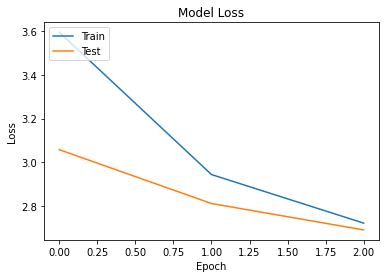

In [0]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [0]:
# dictionary to convert the index to word 
reverse_summary_word_index=y_tokenizer.index_word
reverse_text_word_index=x_tokenizer.index_word
summary_word_index=y_tokenizer.word_index

In [0]:
#Inference
#Encode the input sequence to get the feature vector
encoder_model = Model(inputs=encoder_inputs,outputs=[encoder_outputs, state_h, state_c])

#Decoder 
#hold the states of the previous time step
decoder_state_input_h = Input(shape=(latent_dim,))
decoder_state_input_c = Input(shape=(latent_dim,))
decoder_hidden_state_input = Input(shape=(maximum_text_length,latent_dim))

#embeddings of the decoder sequence
decoder_embedding2= decoder_embedding_layer(decoder_inputs) 
#setting initial states to the states from the previous time step for predicting next word
decoder_outputs2, state_h2, state_c2 = decoder_lstm(decoder_embedding2, initial_state=[decoder_state_input_h, decoder_state_input_c])

#attention inference
attn_out_inf, attn_states_inf = attn_layer([decoder_hidden_state_input, decoder_outputs2])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# A dense final output layer (softmax)
# generate prob distribution over the summary vocabulary
decoder_outputs2 = decoder_dense(decoder_inf_concat) 

# Final decoder model
decoder_model = Model([decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c], [decoder_outputs2] + [state_h2, state_c2])


In [0]:
def predicted(input_seq):
    # Encode the input as state vectors.
    e_out, e_h, e_c = encoder_model.predict(input_seq)
    
    # Generate empty target sequence of length 1.
    sequence = np.zeros((1,1))
    
    # Populate the first word of target sequence with the start word.
    sequence[0, 0] = summary_word_index['starttoken']

    quitt = False
    predicted_summary = ''
    while not quitt:
      
        output_tokens, h, c = decoder_model.predict([sequence] + [e_out, e_h, e_c])

        # Sample a token
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = reverse_summary_word_index[sampled_token_index]
        
        if(sampled_token!='endtoken'):
            predicted_summary += ' '+sampled_token

        # Exit condition: either hit max length or find stop word.
        if (sampled_token == 'endtoken'  or len(predicted_summary.split()) >= (maximum_summary_length-1)):
            quitt = True

        # Update the target sequence (of length 1).
        sequence = np.zeros((1,1))
        sequence[0, 0] = sampled_token_index

        # Update internal states
        e_h, e_c = h, c

    return predicted_summary

In [0]:
def summary(summary):
    original_sum = ''
    for i in summary:
        if((i!= 0 and i!= summary_word_index['starttoken']) and i!= summary_word_index['endtoken']):
            original_sum = original_sum + reverse_summary_word_index[i]+' '
    return original_sum

def text(text):
    original_text = ''
    for i in text:
        if(i!=0):
            original_text = original_text + reverse_text_word_index[i]+' '
    return original_text

for i in range(50):
  print("#",i+1)
  print("Text:",text(text_val[i]))
  print("Original summary:",summary(summary_val[i]))
  print("Predicted summary:",predicted(text_val[i].reshape(1,maximum_text_length)))
  print("\n")


# 1
Text: love cereal never fan cocoa crispies fan erewhon rice cereals decided give shot tasty addictive without disgusting sugary like regular brands find eating breakfast sometimes dessert 
Original summary: addictive and tasty 
Predicted summary:  best cereal ever


# 2
Text: cannot say much product love makes satisfying meal much time desire make better time permits grand kids like mine better 
Original summary: love this product 
Predicted summary:  best i have found


# 3
Text: compared delicious fast noodle one one worst ever little amount mushroom soup tasted like adding artificial ingredients would definitely recommend one may want try kinds flavors 
Original summary: not a good one 
Predicted summary:  not very good


# 4
Text: item came good shape packed well however aware outdoor plant thought order bonsai usually indoor decoration instructions say left outside hope weather irrigation plant die 
Original summary: needs to be outside 
Predicted summary:  not as pictured


#

In [0]:
for i in range(1000):
  print("#",i+1)
  print("Text:",text(text_val[i]))
  print("Original summary:",summary(summary_val[i]))
  print("Predicted summary:",predicted(text_val[i].reshape(1,maximum_text_length)))
  print("\n")


Streaming output truncated to the last 5000 lines.

# 168
Text: actually prefer taste gluten free mac cheese instant flavor kids eating though good sign effortless convenient packaging 
Original summary: easy could use more flavor 
Predicted summary:  good but not great


# 169
Text: tried flavor tastes lot like sprite like aspartame price amazon double get syrups elsewhere buy 
Original summary: diet lemon lime flavor 
Predicted summary:  diet lemon lime flavor


# 170
Text: luzianne chicken coating mix opinion tastiest available little spicy definitely much kids 
Original summary: plain good eats 
Predicted summary:  great for the money


# 171
Text: like white snow white hot chocolate like use expresso machine tastes like ones get expensive ones know names also require much package directions calls 
Original summary: very good flavor 
Predicted summary:  great for cocoa powder


# 172
Text: bought eight packs seven hope good condition one looks darker mold notice ate two pieces disg

In [0]:
#text = Amazing I never read the Harry potter books but was looking for something fantasy esque to read. Enter this book which kept me captivated, on the edge of my seat and emotional all throughout. Go into this book blind trust me, you'll love what you read

text = input("Text: ")

clean = content_cleaner(text)

accepted = []
accepted.append(clean)

accepted = list(map(lambda x: 'starttoken '+ x + ' endtoken', accepted))

#convert text sequences into integer sequences
accepted = x_tokenizer.texts_to_sequences(accepted)
#ensures all sequences in the list have the same length
accepted = pad_sequences(accepted, maxlen = maximum_text_length, padding='post')

print("Predicted: ",predicted(accepted[0].reshape(1,maximum_text_length)))


Text: Amazing I never read the Harry potter books but was looking for something fantasy esque to read. Enter this book which kept me captivated, on the edge of my seat and emotional all throughout. Go into this book blind trust me, you'll love what you read
Predicted:   a must read
